In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedsalem200","key":"b8b7e1ca2832490c73551fff9938380f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d ./brain_tumor_data

Streaming output truncated to the last 5000 lines.
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0721.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0722.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0723.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0724.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0725.jpg  
  inflating: ./brain_tumor_data/Trainin

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import defaultdict

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = "/content/brain_tumor_data"
splits = ['Training', 'Testing']
target_size = (224, 224)
num_classes = 4
class_counts = defaultdict(int)

for split in splits:
    split_dir = os.path.join(data_dir, split)
    print(f"\nSplit: {split}")
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        count = len(os.listdir(cls_path))
        class_counts[(split, cls)] = count
        print(f"  Class '{cls}': {count} images")


Split: Training
  Class 'notumor': 1595 images
  Class 'pituitary': 1457 images
  Class 'glioma': 1321 images
  Class 'meningioma': 1339 images

Split: Testing
  Class 'notumor': 405 images
  Class 'pituitary': 300 images
  Class 'glioma': 300 images
  Class 'meningioma': 306 images


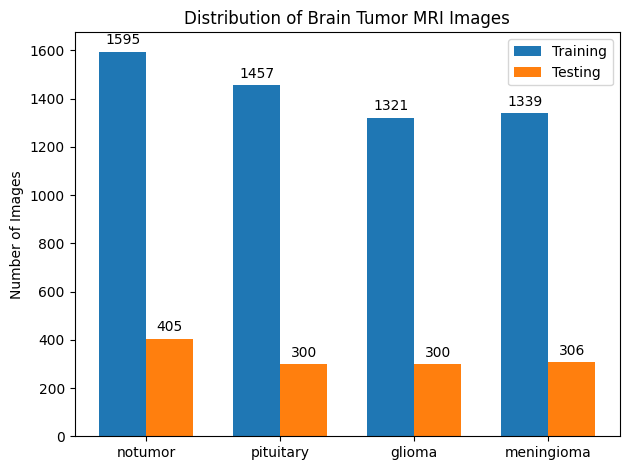

In [ ]:
#Data Visualization
labels = ['notumor', 'pituitary', 'glioma', 'meningioma']
training_data = [class_counts[('Training', label)] for label in labels]
testing_data = [class_counts[('Testing', label)] for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_data, width, label='Training')
rects2 = ax.bar(x + width/2, testing_data, width, label='Testing')


ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Brain Tumor MRI Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)# Show the count of each bar in the Training set.
ax.bar_label(rects2, padding=3)# show the count of each bar in the testing set.

fig.tight_layout()

plt.show()



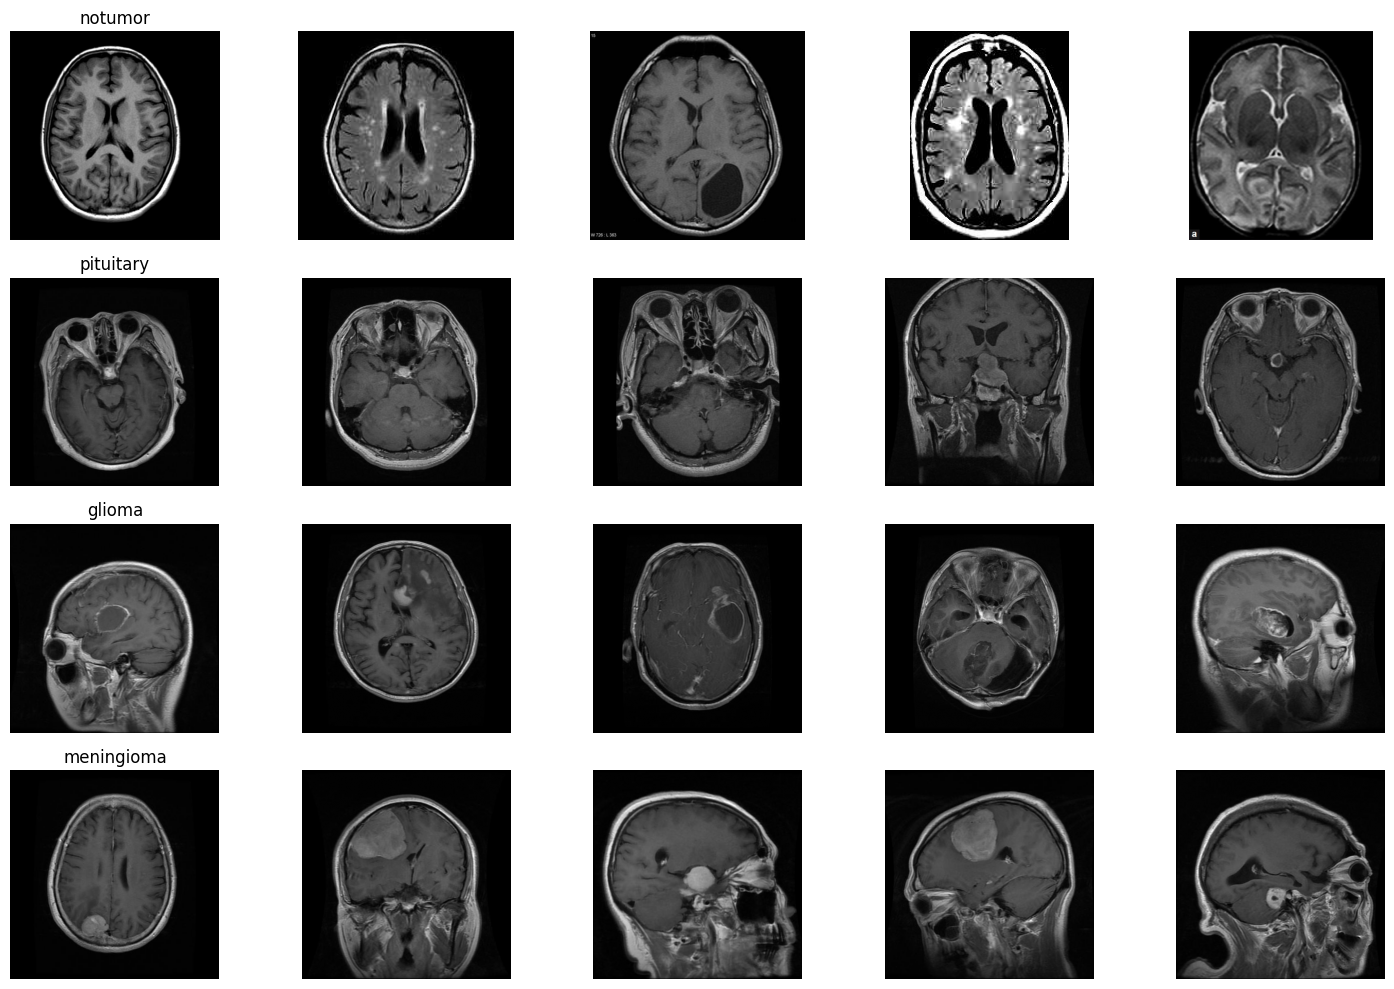

In [ ]:
def show_samples(split='Training', num_samples=5):
    split_path = os.path.join(data_dir, split)
    classes = os.listdir(split_path)

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(split_path, cls)
        images = os.listdir(cls_path)[:num_samples]
        for j in range(num_samples):
            img_path = os.path.join(cls_path, images[j])
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples()


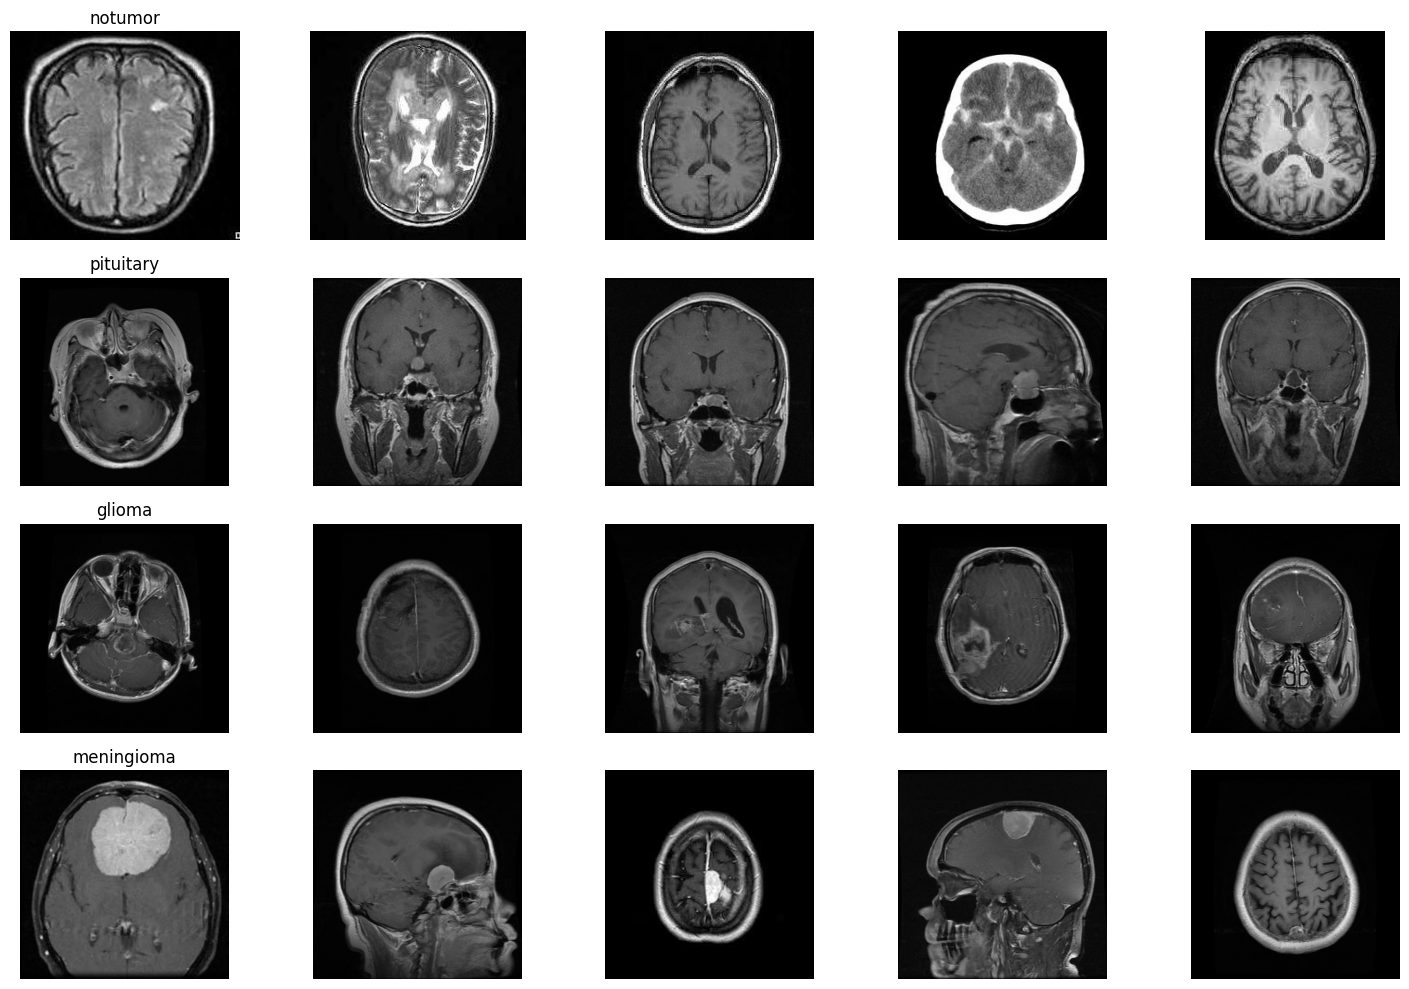

In [ ]:
def show_samples(split='Testing', num_samples=5):
    split_path = os.path.join(data_dir, split)
    classes = os.listdir(split_path)

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(split_path, cls)
        images = os.listdir(cls_path)[:num_samples]
        for j in range(num_samples):
            img_path = os.path.join(cls_path, images[j])
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples()


In [ ]:
def create_dataset(path):
    my_list = []
    for category in labels:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [ ]:
train_df = create_dataset(data_dir+'/'+splits[0]) # Training
test_df = create_dataset(data_dir+'/'+splits[1]) # Testing

In [ ]:
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [ ]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
from tqdm import tqdm

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history

In [ ]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=labels))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60)

Starting training...


 77%|███████▋  | 137/179 [14:32<04:18,  6.16s/it]